Probing the Limits of Domain Adaptation
---
In the last tutorial, we saw an instance of distance-based and adversarial domain adaptation (DA) techniques working to improve the generalization of a NN trained on MNIST and evaluated on MNIST-M. We will now move to a more physical dataset of galaxy morphologies, with the differences between source and target domain due to fundamentally different imaging devices. We will be using the Sinkhorn divergence as our distance metric for DA. 

<img src="https://snehjp2.github.io/images/gaussian_meme.png" alt="gaussian meme" width="600"/>


The particular focus here will be playing around with hyperparameters, illustrating the success and failure points of DA and the importance of finding the right sweet-spot for training. We will end with more sophisticated techniques for implementing DA that can automate-away the need for hyperparameter tuning. We'll start with the same code imports as before:

In [1]:
# torch related inputs
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

import copy

# miscellaneous
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Callable, Optional
import os
import random

# geomloss provides distance measure that are torch/CUDA compatible. 
# uncomment line below to install it, if you don't have it installed.

# !pip install -q geomloss

def set_all_seeds(seed=0):

    os.environ["PYTHONHASHSEED"] = str(seed)  # For Python's hash seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: enforce deterministic algorithms where possible
    torch.use_deterministic_algorithms(True, warn_only=True)
    
set_all_seeds()


Problem Setup
---

Our problem setup follows similarly from Tutorial 1.

- **Neural Network**:  
Let $f_\theta$ denote a neural network classifier with parameters $\theta$, which maps an input image $x \in \mathbb{R}^n$ to predicted class probabilities $\hat{y} = f_\theta(x) \in \mathbb{R}^K$. The network is decomposed into a feature extractor $\phi_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^d$ and a classifier head $g_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^K$, such that $f_\theta(x) = \text{softmax}(g_\theta(\phi_\theta(x)))$.  
We define the **latent representation** $z = \phi_\theta(x)$ as the output of the final hidden layer (before the logits). This representation (also called the *latent vector* or *latent space*) will be used for domain alignment.

- **Source domain dataset**:  
$\mathcal{D}_s = \{(x_s^{(i)}, y_s^{(i)})\}_{i=1}^{N_s}$,  
where $x_s^{(i)} \sim p_s(x)$ are galaxy morphology observations from SDSS, and $y_s^{(i)} \in \{0, 1, \dots, 9\}$ are the corresponding morphology labels.

- **Target domain dataset**:  
$\mathcal{D}_t = \{x_t^{(j)}\}_{j=1}^{N_t}$,  
where $x_t^{(j)} \sim p_t(x)$ are unlabeled galaxy morphology observations from DESI. The included morphologies are the same in both datasets. 
We assume the label distributions are aligned, i.e., $p_s(y|x) = p_t(y|x)$, but the input distributions differ: $p_s(x) \neq p_t(x)$.  
Our goal is to adapt $f_\theta$ using **only labeled source data** and **unlabeled target data**, so that it performs well on the target domain.

- **Classification loss**:  
On the source domain, we minimize the supervised cross-entropy loss between predicted and true labels:

$$
\mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(y_s^{(i)})}(x_s^{(i)}),
$$

where $f_\theta^{(k)}(x)$ denotes the predicted probability for class $k$, and $K = 10$ is the number of classes.

---
Let's start by defining our necessary ingredients, starting with the data. We will download the [Galaxy Zoo Evo Dataset](https://huggingface.co/datasets/mwalmsley/gz_evo) from [this link](https://zenodo.org/uploads/14583107). The dataset is 2.35 GB in size; make sure to place it in the `data/` directory for the code below to run correctly. Galaxy Zoo (GZ) is a citizen science project that labels galaxy images through online participation. GZ Evo combines labeled image datasets across several surveys and iterations of GZ. Within GZ Evo, we use the GZ2 Dataset from the Sloan Digital Sky Survey (SDSS) [Willett et al., 2013] as the source, and a GZ Dark Energy Spectroscopic Instrument (DESI) dataset that combines observations from the DESI Imaging Surveys (DECals, MzLS, BASS, DES) as the target domain.

Recall that images are typically normalized to be in the range [-1,1] for gradient stabilitiy during training. This is done via [z-score normalization](https://en.wikipedia.org/wiki/Standard_score). I've precalculated the means and standard deviations of the datasets for you. Feel free to check this yourself! This is an often not-discussed/overlooked aspect of training NNs, but data normalization is **immensely important**. Lets start by defining our dataset class:


In [2]:
class GZEvo(Dataset):
    """Dataset class for the Galaxy Zoo Evolution dataset.

    Args:
        input_path (str): Path to the input data.
        output_path (Optional[str], optional): Path to the output data. Defaults to None.
        transform (Optional[Callable], optional): Transform to apply to the data. Defaults to None.
    """

    def __init__(
        self,
        input_path: str,
        output_path: Optional[str] = None,
        transform: Optional[Callable] = None,
    ):
        self.input_path = input_path
        self.output_path = output_path
        self.transform = transform

        try:
            self.img = np.load(self.input_path)
            self.label = np.load(self.output_path)
        except Exception as e:
            raise RuntimeError(
                f"Error loading data from {input_path} and {output_path}: {e}"
            )

        self.length = len(self.img)

    def __getitem__(self, idx: int):
        img = self.img[idx]
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.label[idx], dtype=torch.long)
        return img, label

    def __len__(self) -> int:
        return self.length

Like with MNIST-M, we need to be careful about image normalization. I've precalculated the dataset statistics for you again

In [ ]:
data_subset_size = 10000
train_subset_size = int(data_subset_size * 0.8)
test_subset_size = data_subset_size - train_subset_size

sdss_mean = (0.0439, 0.0388, 0.0289)
sdss_std = (0.0816, 0.0687, 0.0590)
desi_mean = (0.1040, 0.0971, 0.0951)
desi_std = (0.0835, 0.0789, 0.0754)

sdss_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=sdss_mean, std=sdss_std),
                transforms.Resize((28, 28)),
            ]
        )

desi_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=desi_mean, std=desi_std),
                transforms.Resize((28, 28)),
            ]
        )

source_train_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/train/x_train_sdss.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/train/y_train_sdss.npy",
    transform=sdss_transform
)

target_train_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/train/x_train_desi.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/train/y_train_desi.npy",
    transform=desi_transform
)

source_test_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/test/x_test_sdss.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/test/y_test_sdss.npy",
    transform=sdss_transform
)

target_test_dataset = GZEvo(
    input_path="./data/galaxy_dataset/galaxy_dataset/test/x_test_desi.npy",
    output_path="./data/galaxy_dataset/galaxy_dataset/test/y_test_desi.npy",
    transform=desi_transform
)

source_train_indices = torch.randperm(len(source_train_dataset))[:train_subset_size]
source_test_indices = torch.randperm(len(source_test_dataset))[:test_subset_size]
target_train_indices = torch.randperm(len(target_train_dataset))[:train_subset_size]
target_test_indices = torch.randperm(len(target_test_dataset))[:test_subset_size]

source_train_dataset = Subset(source_train_dataset, source_train_indices)
source_test_dataset = Subset(source_test_dataset, source_test_indices)
target_train_dataset = Subset(target_train_dataset, target_train_indices)
target_test_dataset = Subset(target_test_dataset, target_test_indices)

source_train_loader = DataLoader(
    source_train_dataset,
    batch_size=64,
    shuffle=True
)
target_train_loader = DataLoader(
    target_train_dataset,
    batch_size=64,
    shuffle=True
)
source_test_loader = DataLoader(
    source_test_dataset,
    batch_size=64,
    shuffle=False
)
target_test_loader = DataLoader(
    target_test_dataset,
    batch_size=64,
    shuffle=False
)

In [4]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for imgs, _ in loader:
        # imgs shape: (B, C, H, W)
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)  # (B, C, H*W)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean, std

# Example: Compute for source training set
mean, std = compute_mean_std(source_train_dataset)
print("Mean:", mean)
print("Std:", std)
mean, std = compute_mean_std(target_train_dataset)
print("Mean:", mean)
print("Std:", std)
mean, std = compute_mean_std(source_test_dataset)
print("Mean:", mean)
print("Std:", std)
mean, std = compute_mean_std(target_test_dataset)
print("Mean:", mean)
print("Std:", std)


Mean: tensor([ 1.7008e-03,  1.4441e-03, -6.5291e-05], dtype=torch.float64)
Std: tensor([0.9296, 0.9277, 0.9186], dtype=torch.float64)
Mean: tensor([0.0016, 0.0028, 0.0023], dtype=torch.float64)
Std: tensor([0.9124, 0.9235, 0.9208], dtype=torch.float64)
Mean: tensor([-0.0026,  0.0031,  0.0042], dtype=torch.float64)
Std: tensor([0.9298, 0.9289, 0.9238], dtype=torch.float64)
Mean: tensor([0.0095, 0.0101, 0.0090], dtype=torch.float64)
Std: tensor([0.9182, 0.9290, 0.9254], dtype=torch.float64)


Now that the data is downloaded, lets just sanity check that the images look like what we would expect.

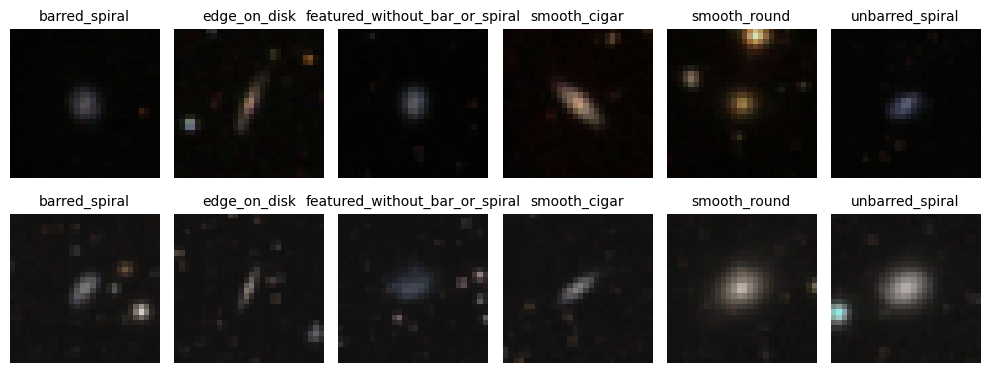

In [ ]:
labels_dict = {'barred_spiral': 0, 
               'edge_on_disk': 1, 
               'featured_without_bar_or_spiral': 2, 
               'smooth_cigar': 3, 
               'smooth_round': 4, 
               'unbarred_spiral': 5
            }
labels_dict = {v: k for k, v in labels_dict.items()}  # Reverse the dictionary for plotting

def get_examples_by_label(dataset):
    label_to_img = {}
    for img, label in dataset:
        label = int(label)
        if label not in label_to_img:
            label_to_img[label] = img
        if len(label_to_img) == 6:
            break
    return label_to_img

# Undo normalization
def unnormalize(img, mean, std):
    img = img.clone()
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

# Collect examples
sdss_galaxy = get_examples_by_label(source_train_dataset)
desi_galaxy = get_examples_by_label(target_train_dataset)

# Plotting
fig, axes = plt.subplots(2, 6, figsize=(10, 4))

for i in range(6):
    # SDSS (top row)
    image_sdss = unnormalize(sdss_galaxy[i], sdss_mean, sdss_std)
    axes[0, i].imshow(image_sdss.permute(1, 2, 0).numpy())
    # use labels from labels_dict
    axes[0, i].set_title(f"{labels_dict[i]}", fontsize=10)
    axes[0, i].axis("off")

    # DESI (bottom row)
    image_desi = unnormalize(desi_galaxy[i], desi_mean, desi_std)
    axes[1, i].imshow(image_desi.permute(1, 2, 0).numpy())
    axes[1, i].set_title(f"{labels_dict[i]}", fontsize=10)
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("SDSS", fontsize=12)
axes[1, 0].set_ylabel("DESI", fontsize=12)
plt.tight_layout()
plt.show()


Images look good, now lets just check that the shapes are the same for training, and that the z-score normalization statistics look ok.

In [6]:
# Get a sample image from each dataset
sdss_image = next(iter(DataLoader(source_test_dataset, batch_size=1)))[0]
desi_image = next(iter(DataLoader(source_train_dataset, batch_size=1)))[0]

# Print the shapes
print("SDSS image shape:", sdss_image.shape) # should be (3, 28, 28)
print("DESI image shape:", desi_image.shape) # should be (3, 28, 28)
print("SDSS image stats:", torch.mean(sdss_image), torch.std(sdss_image)) # should be close to 0 and 1
print("DESI image stats:", torch.mean(desi_image), torch.std(desi_image)) # should be close to 0 and 1

SDSS image shape: torch.Size([1, 3, 28, 28])
DESI image shape: torch.Size([1, 3, 28, 28])
SDSS image stats: tensor(0.3389, dtype=torch.float64) tensor(1.2147, dtype=torch.float64)
DESI image stats: tensor(0.0340, dtype=torch.float64) tensor(1.0110, dtype=torch.float64)


---
Now let's define our model. We will use the same CNN architecture from the previous tutorial. We've added [layer normalization](https://arxiv.org/abs/1607.06450) before returning the latent space to help stabalize the representations. 

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_dim = 32 * 14 * 14  # for input images of shape (3, 50, 50)

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.ln1 = nn.LayerNorm(128)  # apply to latent vector
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        z = x.view(-1, self.flatten_dim)
        z = F.relu(self.fc1(z))
        z = self.ln1(z)  # apply LayerNorm to the latent vector
        out = self.fc2(z)
        return out, z


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
CE_only_model = CNN(num_classes=6).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(CE_only_model.parameters(), lr=1e-3)
best_model = None
best_loss = float('inf')
# Training loop
num_epochs = 4
for epoch in tqdm(range(num_epochs)):
    CE_only_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in source_train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.float()

        # Forward pass
        outputs, _ = CE_only_model(images) ## not using latent z for now
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(CE_only_model.state_dict())


        # Track training stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/len(source_train_loader):.4f}  Accuracy: {100*correct/total:.2f}%")

Using device: cpu


 25%|██▌       | 1/4 [00:03<00:11,  4.00s/it]

Epoch [1/4]  Loss: 1.1451  Accuracy: 57.39%


 50%|█████     | 2/4 [00:07<00:07,  3.93s/it]

Epoch [2/4]  Loss: 0.7647  Accuracy: 71.56%


 75%|███████▌  | 3/4 [00:11<00:03,  3.98s/it]

Epoch [3/4]  Loss: 0.6944  Accuracy: 73.90%


100%|██████████| 4/4 [00:15<00:00,  3.97s/it]

Epoch [4/4]  Loss: 0.6248  Accuracy: 76.84%


In [9]:
def test_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            outputs, _ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Test on source domain (MNIST)
CE_only_model.load_state_dict(best_model)
source_accuracy = test_model(CE_only_model, source_test_loader, device)
print(f"Accuracy on source domain (SDSS): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(CE_only_model, target_test_loader, device)
print(f"Accuracy on target domain (DESI): {target_accuracy:.2f}%")

Accuracy on source domain (SDSS): 73.10%
Accuracy on target domain (DESI): 61.05%


We see that the model has a slight % discrepancy between the source and target domain. Indeed, despite the galaxy observations coming from fundamentally different imaging instruments, the images dont look *too* different. Can you think about why the two datasets look similar despite coming from SDSS and DESI? Think about the photometric filters used in both surveys, and their wavelength coverage. 

*Stretch Question:* Would you expect galaxy observations from JWST and DESI to look similar? What would be different about constructing a model that generalizes between SDSS and JWST observations? What kind of domain shift would this be?

Now, lets move to domain adaptation and see if we can shrink this performance gap between $\mathcal{D}_s$ and $\mathcal{D}_t$. We will again use `geomloss`, but this time using the Sinkhorn Divergence.

---

The Sinkhorn Divergence
---

The optimal transport (OT) distance is distance measure much like MMD. One notable problem with MMD distances is the user-specified choice of kernel function $k$. There are several principled kernel options (e.g., Gaussian, Lapllacian, linear, etc.) with the optimal choice of kernel determined through extensive experimentation. A single kernel may not be optimal, either, and a superposition of kernels may be needed for optimal domain alignment. OT distances avoid this by not requiring a kernel function in computing distances, and have gained popularity in recent years due to *entropic regularization* making the calculation of such distances more manageable. The regularized OT is defined as

$$
\text{OT}_\sigma(\mu, \nu) = \min_{\gamma \in U(\mu, \nu)} \left( \sum_{i,j} \gamma_{ij} d(z_i, z_j^*)^p + \sigma H(\gamma) \right),
$$

where $d(z_i, z_j^*)^p$ is the distance between source feature $z_i$ and target feature $z_j^*$. When $p = 1$, this distance becomes the Earth Mover’s Distance [Rubner et al., 1998], and when \( p = 2 \), it becomes the quadratic Wasserstein distance.

The transport plan $\gamma \in U(\mu, \nu)$ is a joint probability distribution between $\mu$ and $\nu$, where the set of admissible transport plans $U(\mu, \nu)$ is defined by the marginal constraints:

$$
\sum_j \gamma_{ij} = \mu_i, \quad \sum_i \gamma_{ij} = \nu_j. \tag{4}
$$

Much of the expense in the regularized OT problem is finding measures that satisfy these constraints. The entropy $H(\gamma) = -\sum_{i,j} \gamma_{ij} \log \gamma_{ij}$ regularizes the transport plan $\gamma$, and $\sigma$ controls the regularization strength (this is sometimes referred to as the "blur" parameter). One limitation of $\text{OT}_\sigma$ is that $\text{OT}_\sigma(\mu, \mu) \ne 0$, implying a non-zero cost even when transporting a distribution to itself, leading to bias in the measure.

To correct this bias, the Sinkhorn divergence $S_\sigma(\mu, \nu)$, defined as

$$
S_\sigma(\mu, \nu) = \text{OT}_\sigma(\mu, \nu) - \frac{1}{2} \text{OT}_\sigma(\mu, \mu) - \frac{1}{2} \text{OT}_\sigma(\nu, \nu), \tag{5}
$$

can compensate for the bias in $\text{OT}_\sigma$ [Feydy et al., 2018]. As $\sigma \to 0$, $S_\sigma(\mu, \nu)$ converges to the (biased) optimal transport $\text{OT}_0$, and as $\sigma \to \infty$, it interpolates towards MMD loss [Feydy et al., 2018]. For small values of $\sigma$, an unbiased transport plan that still enjoys the benefits of OT-based distances can be constructed. We're now ready for our full loss function:

$$
\mathcal{L} = \mathcal{L}_{\text{CE}}(y_s, \hat{y}_s) + \lambda \cdot S_\sigma(z, z^*),
$$

where $\lambda$ dictates the strength of the DA loss term.

A few understanding checks before we move forward:
* Double check that the Sinkhorn Divergence is unbiased: $S_\sigma(\mu, \mu) = S_\sigma(\nu, \nu) = 0$. What would happen if you performed DA with a biased measure ($\text{OT}(\mu, \nu)$)?
* There is one hyperparameter here. What is the reason for having $\sigma \to 0$ vs. $\sigma \to \infty$? Think also about computational complexity / speed.
* What would happen when training with $\lambda \to 0$. What about the opposite, when $\lambda \gg 1$?

Our focus for these next code blocks will be the $\lambda$ term and one technique to finding the optimal balance between the primary learning objective and DA. Lets start with $\lambda \to 0$. We will use a fixed value of $\sigma = 10$; this is still nearly $\mathcal{O}(1)$, but no so small that the Sinkhorn iterations become very expensive.

In [10]:
from geomloss import SamplesLoss

num_epochs = 10
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DA_model = CNN().to(device)  # CNN should return (logits, z)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=5e-3)
lambda_mmd = 0.0001
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

# --- Training ---
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        # --- Concatenate images and forward ---
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # --- Split latent vectors and outputs ---
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # --- Compute losses ---
        ce_loss = criterion(logits_s, source_labels)
        mmd_loss = geomloss_fn(z_s, z_t)  # ← GeomLoss replaces MMD here
        total_loss = ce_loss + lambda_mmd * mmd_loss
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # --- Backpropagation ---
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Metrics ---
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += mmd_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cpu


 10%|█         | 1/10 [00:06<00:58,  6.48s/it]

Epoch [1/10], CE Loss: 1.1967, DA Loss: 0.2724 Source Acc: 54.46%, Target Acc: 48.36%


 20%|██        | 2/10 [00:13<00:53,  6.64s/it]

Epoch [2/10], CE Loss: 0.7960, DA Loss: 1.5491 Source Acc: 70.35%, Target Acc: 55.74%


 30%|███       | 3/10 [00:20<00:47,  6.79s/it]

Epoch [3/10], CE Loss: 0.7173, DA Loss: 2.5587 Source Acc: 73.04%, Target Acc: 57.76%


 40%|████      | 4/10 [00:26<00:39,  6.52s/it]

Epoch [4/10], CE Loss: 0.6835, DA Loss: 2.7770 Source Acc: 74.29%, Target Acc: 59.30%


 50%|█████     | 5/10 [00:32<00:32,  6.43s/it]

Epoch [5/10], CE Loss: 0.6238, DA Loss: 3.2094 Source Acc: 76.04%, Target Acc: 58.50%


 60%|██████    | 6/10 [00:38<00:25,  6.38s/it]

Epoch [6/10], CE Loss: 0.5959, DA Loss: 3.6147 Source Acc: 77.14%, Target Acc: 58.45%


 70%|███████   | 7/10 [00:44<00:18,  6.27s/it]

Epoch [7/10], CE Loss: 0.5513, DA Loss: 3.8574 Source Acc: 79.42%, Target Acc: 58.52%


 80%|████████  | 8/10 [00:51<00:12,  6.29s/it]

Epoch [8/10], CE Loss: 0.4970, DA Loss: 4.0979 Source Acc: 80.96%, Target Acc: 58.39%


 90%|█████████ | 9/10 [00:57<00:06,  6.17s/it]

Epoch [9/10], CE Loss: 0.4439, DA Loss: 4.7558 Source Acc: 83.04%, Target Acc: 58.33%


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]

Epoch [10/10], CE Loss: 0.3964, DA Loss: 5.3365 Source Acc: 84.69%, Target Acc: 59.06%


In [11]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 73.10%
Accuracy on target domain (MNIST-M): 61.90%


Ok, so virtually no improvement here. In this case, the DA term isn't contributing meaningfully to the loss landscape. A reasonable guess would be that $\lambda$ should be less than 1, but it is hard to guess a priori whether it should be $\mathcal{O}(0.1)$, $\mathcal{O}(0.01)$, etc. For a different dataset, a $\lambda$ value as small as whats used above could be appropriate - it's hard to tell without an explicit search.

Let's now test the opposite limit, with a much larger $\lambda$ value.

In [12]:
num_epochs = 10
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DA_model = CNN().to(device)  # CNN should return (logits, z)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=5e-3)
lambda_mmd = 1000
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=.1) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

# --- Training ---
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        # --- Concatenate images and forward ---
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # --- Split latent vectors and outputs ---
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # --- Compute losses ---
        ce_loss = criterion(logits_s, source_labels)
        mmd_loss = geomloss_fn(z_s, z_t)  # ← GeomLoss replaces MMD here
        total_loss = ce_loss + lambda_mmd * mmd_loss
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # --- Backpropagation ---
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Metrics ---
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += mmd_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cpu


 10%|█         | 1/10 [00:06<00:55,  6.11s/it]

Epoch [1/10], CE Loss: 1.5179, DA Loss: 0.2504 Source Acc: 42.14%, Target Acc: 46.90%


 20%|██        | 2/10 [00:11<00:46,  5.85s/it]

Epoch [2/10], CE Loss: 1.4942, DA Loss: 0.0012 Source Acc: 43.36%, Target Acc: 48.75%


 30%|███       | 3/10 [00:17<00:41,  5.87s/it]

Epoch [3/10], CE Loss: 1.4846, DA Loss: 0.0003 Source Acc: 43.71%, Target Acc: 49.04%


 40%|████      | 4/10 [00:23<00:36,  6.03s/it]

Epoch [4/10], CE Loss: 1.4870, DA Loss: 0.0002 Source Acc: 43.71%, Target Acc: 49.04%


 50%|█████     | 5/10 [00:30<00:30,  6.16s/it]

Epoch [5/10], CE Loss: 1.4846, DA Loss: 0.0001 Source Acc: 43.71%, Target Acc: 49.04%


 60%|██████    | 6/10 [00:36<00:24,  6.23s/it]

Epoch [6/10], CE Loss: 1.4898, DA Loss: 0.0001 Source Acc: 43.71%, Target Acc: 49.04%


 70%|███████   | 7/10 [00:42<00:18,  6.25s/it]

Epoch [7/10], CE Loss: 1.4867, DA Loss: 0.0001 Source Acc: 43.30%, Target Acc: 48.61%


 80%|████████  | 8/10 [00:49<00:12,  6.30s/it]

Epoch [8/10], CE Loss: 1.4928, DA Loss: 0.0001 Source Acc: 43.27%, Target Acc: 48.60%


 90%|█████████ | 9/10 [00:57<00:06,  6.99s/it]

Epoch [9/10], CE Loss: 1.4808, DA Loss: 0.0001 Source Acc: 43.31%, Target Acc: 48.66%


100%|██████████| 10/10 [01:05<00:00,  6.57s/it]

Epoch [10/10], CE Loss: 1.4799, DA Loss: 0.0001 Source Acc: 43.74%, Target Acc: 49.05%


In [13]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 43.55%
Accuracy on target domain (MNIST-M): 50.10%


This was clearly too much DA...and not great performance either. And in this case, we can see that the target domain performance is better than the source! Clearly the loss function didn't let the model learn to classify galaxies properly in the first place, because the DA was too strong.

So how can we be certain we're doing things optimally? What one would usually think to do in this case is some sort of search, trying out different values of $\lambda$ within an appropriate range and seeing what works best. But also, the results could be sensitive to the choice of seed, so you should marginalize over multiple realizations and make it a grid search. But also, we havent even thought about what to do with $\sigma$, which is important as well, so maybe a cube search...?

I think you see where this is going. There's a lot of things that are important here. Here, I'll talk about a *trainable* way to avoid the $\lambda$ search, using an idea from Bayesian inference. See [this paper](https://arxiv.org/abs/1705.07115).

The overall idea is two introduce trainable coefficients for the two loss terms. Let us introduce two trainable scalar parameters $\eta_1$ and $\eta_2$, and define the following loss function:

$$
\mathcal{L} = \frac{1}{2 \eta_1} \mathcal{L}_\text{CE} + \frac{1}{2 \eta_2} \mathcal{L}_\text{DA} + \log(|\eta_1 \eta_2|) 
$$

These values can then be optimized jointly with the model parameters, avoiding the need for a user-specified weighting for the loss terms.

Let's think about this loss function before proceeding: 

* What happens to each loss term as its corresponding $\eta_i \to 0$.
* What does the third term $\log(|\eta_1 \eta_2|)$ do?
* We saw that strongly preffering $\mathcal{L}_\text{DA}$ over $\mathcal{L}_\text{CE}$ will result in bad performance. This trainable prescription does not know a priori that doing so is bad. Is there any way to enforce this? *Hint*: Think about what range the parameters should be in.

In [14]:
num_epochs = 10
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DA_model = CNN().to(device)  # CNN should return (logits, z)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

## initialize trainable coefficients
eta_1 = nn.Parameter(torch.tensor(0.1, requires_grad=True))  # Coefficient for CE loss
eta_2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))  #

optimizer.add_param_group({"params": [eta_1, eta_2]})

# --- Training ---
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        # --- Concatenate images and forward ---
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # --- Split latent vectors and outputs ---
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # --- Compute losses ---
        ce_loss = criterion(logits_s, source_labels)
        mmd_loss = geomloss_fn(z_s, z_t)  # ← GeomLoss replaces MMD here
        total_loss = (2 * eta_1**2)**-1 * ce_loss + (2 * eta_2**2)**-1 * mmd_loss + torch.log(eta_1 * eta_2)  # ← Using trainable coefficients
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # --- Backpropagation ---
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        eta_1.data.clamp_(min=1e-3)
        eta_2.data.clamp_(min=0.25*eta_1.data.item())
        optimizer.step()

        # --- Metrics ---
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += mmd_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cpu


 10%|█         | 1/10 [00:06<01:02,  6.92s/it]

Epoch [1/10], CE Loss: 1.0649, DA Loss: 0.7426 Source Acc: 61.80%, Target Acc: 53.52% eta_1: 0.16757038235664368 eta_2: 0.962223470211029


 20%|██        | 2/10 [00:12<00:51,  6.42s/it]

Epoch [2/10], CE Loss: 0.7855, DA Loss: 0.9814 Source Acc: 70.90%, Target Acc: 58.69% eta_1: 0.19984300434589386 eta_2: 0.9710079431533813


 30%|███       | 3/10 [00:19<00:43,  6.26s/it]

Epoch [3/10], CE Loss: 0.7083, DA Loss: 0.8384 Source Acc: 73.79%, Target Acc: 60.76% eta_1: 0.22405940294265747 eta_2: 0.9531427025794983


 40%|████      | 4/10 [00:25<00:37,  6.29s/it]

Epoch [4/10], CE Loss: 0.6522, DA Loss: 0.8060 Source Acc: 75.38%, Target Acc: 61.34% eta_1: 0.24363020062446594 eta_2: 0.9321667551994324


 50%|█████     | 5/10 [00:32<00:32,  6.58s/it]

Epoch [5/10], CE Loss: 0.6171, DA Loss: 0.7022 Source Acc: 77.31%, Target Acc: 62.34% eta_1: 0.26035505533218384 eta_2: 0.8960933089256287


 60%|██████    | 6/10 [00:38<00:25,  6.43s/it]

Epoch [6/10], CE Loss: 0.5795, DA Loss: 0.6033 Source Acc: 78.65%, Target Acc: 63.12% eta_1: 0.2748684287071228 eta_2: 0.8479979038238525


 70%|███████   | 7/10 [00:44<00:19,  6.36s/it]

Epoch [7/10], CE Loss: 0.5495, DA Loss: 0.4910 Source Acc: 80.10%, Target Acc: 63.83% eta_1: 0.2879581153392792 eta_2: 0.7836197018623352


 80%|████████  | 8/10 [00:51<00:12,  6.35s/it]

Epoch [8/10], CE Loss: 0.5048, DA Loss: 0.4716 Source Acc: 81.55%, Target Acc: 63.58% eta_1: 0.29913079738616943 eta_2: 0.7349061965942383


 90%|█████████ | 9/10 [00:57<00:06,  6.30s/it]

Epoch [9/10], CE Loss: 0.4799, DA Loss: 0.4028 Source Acc: 82.85%, Target Acc: 63.76% eta_1: 0.30937638878822327 eta_2: 0.6769939064979553


100%|██████████| 10/10 [01:02<00:00,  6.30s/it]

Epoch [10/10], CE Loss: 0.4461, DA Loss: 0.3634 Source Acc: 84.34%, Target Acc: 64.03% eta_1: 0.31849029660224915 eta_2: 0.6268103122711182


In [15]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 74.55%
Accuracy on target domain (MNIST-M): 66.05%


In this case you've seen that we've outperformed no-DA and both fixed-coefficient DA examples by ~5%, without any grid search whatsoever! This trainable prescription largely avoided the need to tune these hyperparameters. Keep in mind we did use some inductive bias: we initialized the $\eta_i$ differently (think as to why we did this), and clipped them in some reasonable way. This was simply to give the parameters a nudge in the right direction.

The last thing we want to study is our treatment of $\sigma$. In the last experiments, we used a fixed value of $\sigma = 10$, but now lets think about the assumption that a single value of $\sigma$ is optimal. It may not be.

Keep in mind that as $\sigma \to 0$ the Sinkhorn plan interpolates closer to $\text{OT}_0$, and $\sigma \to \infty$ interpolates closer to MMD. Further, MMD is cheaper to compute than $\text{OT}_0$ (fewer Sinkhorn iterations).

Let's now try a simple annealing scheme, so that $\sigma$ is larger at the beginning of training, when the latent spaces are very misaligned, and smaller at the end, when we want to really focus on domain alignment.

Consider the $\sigma$ scheduler given by:

$$
\sigma = 0.05 * 0.95^\ell \quad \text{where} \; \ell \; \text{is epoch number}
$$

We will test this below

In [16]:
num_epochs = 10
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DA_model = CNN().to(device)  # CNN should return (logits, z)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

## initialize trainable coefficients
eta_1 = nn.Parameter(torch.tensor(0.1, requires_grad=True))  # Coefficient for CE loss
eta_2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))  #

optimizer.add_param_group({"params": [eta_1, eta_2]})

# --- Training ---
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        # --- Concatenate images and forward ---
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # --- Split latent vectors and outputs ---
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # --- Compute losses ---
        ce_loss = criterion(logits_s, source_labels)
        dynamic_blur = 10 * 0.95**epoch
        mmd_loss = geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=dynamic_blur)(z_s, z_t)  # ← GeomLoss replaces MMD here
        total_loss = (2 * eta_1**2)**-1 * ce_loss + (2 * eta_2**2)**-1 * mmd_loss + torch.log(eta_1 * eta_2)  # ← Using trainable coefficients
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # --- Backpropagation ---
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        eta_1.data.clamp_(min=1e-3)
        eta_2.data.clamp_(min=0.25*eta_1.data.item())
        optimizer.step()

        # --- Metrics ---
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += mmd_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cpu


 10%|█         | 1/10 [00:06<00:55,  6.22s/it]

Epoch [1/10], CE Loss: 1.0962, DA Loss: 0.6699 Source Acc: 61.09%, Target Acc: 51.83% eta_1: 0.16784130036830902 eta_2: 0.953438401222229


 20%|██        | 2/10 [00:12<00:49,  6.20s/it]

Epoch [2/10], CE Loss: 0.7716, DA Loss: 0.8929 Source Acc: 71.50%, Target Acc: 56.96% eta_1: 0.1990041434764862 eta_2: 0.9502055048942566


 30%|███       | 3/10 [00:18<00:44,  6.29s/it]

Epoch [3/10], CE Loss: 0.7016, DA Loss: 0.8773 Source Acc: 73.80%, Target Acc: 58.26% eta_1: 0.22279058396816254 eta_2: 0.942546546459198


 40%|████      | 4/10 [00:25<00:38,  6.35s/it]

Epoch [4/10], CE Loss: 0.6541, DA Loss: 0.7759 Source Acc: 75.46%, Target Acc: 59.29% eta_1: 0.2422061413526535 eta_2: 0.918634295463562


 50%|█████     | 5/10 [00:31<00:31,  6.39s/it]

Epoch [5/10], CE Loss: 0.6058, DA Loss: 0.6485 Source Acc: 77.34%, Target Acc: 60.80% eta_1: 0.2584995627403259 eta_2: 0.8739157915115356


 60%|██████    | 6/10 [00:38<00:25,  6.37s/it]

Epoch [6/10], CE Loss: 0.5537, DA Loss: 0.6054 Source Acc: 79.10%, Target Acc: 61.16% eta_1: 0.2724589407444 eta_2: 0.8333373069763184


 70%|███████   | 7/10 [00:45<00:20,  6.78s/it]

Epoch [7/10], CE Loss: 0.5264, DA Loss: 0.5404 Source Acc: 80.96%, Target Acc: 61.67% eta_1: 0.28491702675819397 eta_2: 0.7866923809051514


 80%|████████  | 8/10 [00:52<00:13,  6.64s/it]

Epoch [8/10], CE Loss: 0.4876, DA Loss: 0.4750 Source Acc: 82.54%, Target Acc: 62.75% eta_1: 0.29583096504211426 eta_2: 0.7372545599937439


 90%|█████████ | 9/10 [00:57<00:06,  6.35s/it]

Epoch [9/10], CE Loss: 0.4490, DA Loss: 0.3963 Source Acc: 84.35%, Target Acc: 62.26% eta_1: 0.3053573668003082 eta_2: 0.6750503778457642


100%|██████████| 10/10 [01:03<00:00,  6.39s/it]

Epoch [10/10], CE Loss: 0.4207, DA Loss: 0.3331 Source Acc: 85.59%, Target Acc: 62.83% eta_1: 0.3140632212162018 eta_2: 0.6141291260719299


In [17]:
# Test on source domain (SDSS)
DA_model.load_state_dict(best_model)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (DESI)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 73.30%
Accuracy on target domain (MNIST-M): 66.25%


Ok, we see in this case the scheduler for $\sigma$ does not change things that much. Thats ok! We have shown in [this paper](https://arxiv.org/abs/2501.14048) that a $\sigma$ scheduler based on the 2-norm between latent spaces not only results in better performance on both domains, but is also significantly faster